In [ ]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import alphashape
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point, MultiPoint, Polygon
from tqdm.auto import tqdm  # Barra de progresso para monitorar as 75 UBS
import matplotlib.pyplot as plt

# Configuração para exibir todas as colunas do Pandas (útil para debug)
pd.set_option('display.max_columns', None)

In [3]:
# --- CÉLULA 2: Carregar Dados ---

# Caminhos dos arquivos (Ajuste conforme sua pasta)
path_grafo = "dados/overturemaps/intermediarios/finais/grafo_arestas.parquet"  # Saída do Notebook 01
path_ubs = "dados/semplam/ubs_zu.geojson"   # Seu arquivo original de UBS

print("--- Carregando Camadas ---")

# 1. Carregar Grafo (Arestas)
arestas_gdf = gpd.read_parquet(path_grafo)
print(f"Grafo carregado: {len(arestas_gdf)} segmentos de via.")

# 2. Carregar UBS
ubs_gdf = gpd.read_file(path_ubs)
print(f"Pontos de Oferta carregados: {len(ubs_gdf)} UBS.")

# 3. Validação de Projeção
if arestas_gdf.crs != ubs_gdf.crs:
    print(f"CRS das aretas = {arestas_gdf.crs.to_string()} e CRS das UBS = {ubs_gdf.crs.to_string()}")
    print("⚠️ AVISO: CRSs diferentes detectados! Reprojetando UBS para o CRS do grafo...")
    ubs_gdf = ubs_gdf.to_crs(arestas_gdf.crs)

print(f"CRS de Trabalho: {arestas_gdf.crs.name} (Deve ser UTM 23S)")

print("Carregando grafo e UBS...")

--- Carregando Camadas ---
Grafo carregado: 44733 segmentos de via.
Pontos de Oferta carregados: 75 UBS.
CRS das aretas = EPSG:31983 e CRS das UBS = EPSG:4674
⚠️ AVISO: CRSs diferentes detectados! Reprojetando UBS para o CRS do grafo...
CRS de Trabalho: SIRGAS 2000 / UTM zone 23S (Deve ser UTM 23S)
Carregando grafo e UBS...


In [4]:
print("--- Construindo Topologia da Rede ---")

# Criar Grafo Direcionado (respeita mão única se os dados tiverem essa info)
# Se o dado do Overture não tiver direção explícita confiável, o DiGraph assume
# o sentido do desenho da linha. (Para máxima precisão, idealmente se trataria 'oneway').
G = nx.from_pandas_edgelist(
    arestas_gdf, 
    source='split_from', 
    target='split_to', 
    edge_attr='travel_time_min',
    create_using=nx.DiGraph()
)
print(f"Grafo montado com sucesso: {len(G.nodes)} nós e {len(G.edges)} conexões.")

--- Construindo Topologia da Rede ---
Grafo montado com sucesso: 82788 nós e 44733 conexões.


In [5]:
# --- EXTRAÇÃO DE COORDENADAS DOS NÓS ---
# O algoritmo Alpha Shape precisa desenhar um polígono em volta de PONTOS (x, y).
# O NetworkX sabe quem conecta com quem, mas não "sabe" onde eles estão no mapa.
# Vamos criar um dicionário {ID_DO_NO: (X, Y)} varrendo as geometrias das linhas.

print("Mapeando coordenadas geográficas dos nós...")
nos_coords = {}

# Iteramos sobre as arestas para "pescar" as coordenadas dos nós de início e fim
for row in tqdm(arestas_gdf.itertuples(), total=len(arestas_gdf), desc="Extraindo geometria"):
    # Acessa a geometria da linha
    coords = row.geometry.coords
    
    # Ponto Inicial (From Node)
    if row.split_from not in nos_coords:
        nos_coords[row.split_from] = {'x': coords[0][0], 'y': coords[0][1]}
    
    # Ponto Final (To Node)
    if row.split_to not in nos_coords:
        nos_coords[row.split_to] = {'x': coords[-1][0], 'y': coords[-1][1]}

# Injetar essas coordenadas dentro do objeto Grafo (para facilitar acesso futuro)
nx.set_node_attributes(G, nos_coords)

Mapeando coordenadas geográficas dos nós...


Extraindo geometria: 100%|██████████| 44733/44733 [00:01<00:00, 28049.49it/s]


In [6]:
print("--- Conectando as 75 UBS à Rede Viária ---")

# 1. Preparar a árvore de busca com todos os nós da rede
ids_dos_nos = list(nos_coords.keys())
# Cria uma matriz numpy com as coordenadas [[x1, y1], [x2, y2]...]
coordenadas_nos = np.array([[data['x'], data['y']] for data in nos_coords.values()])

tree = cKDTree(coordenadas_nos)

# 2. Buscar o vizinho mais próximo para cada UBS
# k=1 significa "me dê apenas o 1º mais próximo"
coords_ubs = list(zip(ubs_gdf.geometry.x, ubs_gdf.geometry.y))
distancias, indices = tree.query(coords_ubs, k=1)

# 3. Atribuir o ID do nó encontrado à tabela de UBS
# 'indices' traz a posição na lista 'ids_dos_nos', precisamos pegar o ID real
ubs_gdf['no_origem_id'] = [ids_dos_nos[i] for i in indices]
ubs_gdf['distancia_ate_rede_m'] = distancias # Bom para controle de qualidade

# Check rápido: Se alguma UBS ficou muito longe da rede (>500m), pode indicar erro no mapa
print(f"Distância média da UBS até a rua: {ubs_gdf['distancia_ate_rede_m'].mean():.2f} metros")

--- Conectando as 75 UBS à Rede Viária ---
Distância média da UBS até a rua: 33.43 metros


In [7]:
def calcular_isocrona_precisa(grafo, id_no_origem, tempo_limite_min, alpha=0.00002):
    """
    Calcula o polígono de acessibilidade (isócrona) a partir de um nó.
    """
    
    # Se o nó não estiver no grafo (erro de dados), retorna vazio
    if id_no_origem not in grafo:
        return None

    try:
        # 1. ROTEAMENTO (Service Area)
        # Retorna um dicionário {id_no: tempo_gasto} para todos os nós alcançáveis
        nos_alcancados = nx.single_source_dijkstra_path_length(
            grafo, 
            source=id_no_origem, 
            cutoff=tempo_limite_min, 
            weight='travel_time_min'
        )
        
        # 2. RECUPERAÇÃO DE GEOMETRIA
        # Transforma os IDs dos nós em pontos (x, y) reais
        pontos_nuvem = []
        for node_id in nos_alcancados.keys():
            # Acesso direto ao atributo que salvamos antes (rápido)
            node_data = grafo.nodes[node_id]
            pontos_nuvem.append((node_data['x'], node_data['y']))
        
        # Validação mínima: precisa de pelo menos 3 ou 4 pontos para fazer uma área
        if len(pontos_nuvem) < 4:
            return None 
            
        # 3. GERAÇÃO DO POLÍGONO (Alpha Shape)
        # O parâmetro alpha controla o detalhe.
        # 0 = Convex Hull. Valores maiores = mais detalhe (e risco de ilhas).
        # Para UTM, 0.00002 costuma ser um bom equilíbrio para escalas urbanas.
        poligono_alpha = alphashape.alphashape(pontos_nuvem, alpha)
        
        # Às vezes o resultado é um MultiPolygon ou GeometryCollection. 
        # Garantimos que retornamos algo válido.
        if poligono_alpha.is_empty:
            return None
            
        return poligono_alpha

    except Exception as e:
        print(f"Erro ao calcular para nó {id_no_origem}: {e}")
        return None

In [8]:
print("--- Iniciando Cálculo Massivo de Isócronas ---")

# Lista para armazenar os resultados (dicionários são leves)
resultados_isocronas = []

# Definição das faixas de tempo para o AE2SFCA (intervalos discretos)
# Calcularemos acumulado e depois faremos a diferença (donuts) se necessário,
# mas para o método AE2SFCA puro, ter os polígonos de 10, 20 e 30 é o ideal.
faixas_tempo = [10, 20, 30] 

# Loop principal com barra de progresso
# iterrows é lento, mas para 75 itens é insignificante. O gargalo é o Dijkstra.
for idx, row in tqdm(ubs_gdf.iterrows(), total=len(ubs_gdf), desc="Processando UBS"):
    
    id_ubs = row.get('cnes') # Ou outro ID único que você tenha
    no_origem = row['no_origem_id']
    
    for tempo in faixas_tempo:
        # Chama a função mágica
        poly = calcular_isocrona_precisa(G, no_origem, tempo, alpha=0.00002)
        
        if poly:
            resultados_isocronas.append({
                'id_ubs': id_ubs,
                'nome_ubs': row.get('nome_fantasia', f'UBS_{idx}'), # Se tiver nome
                'tempo_limite': tempo,
                'geometry': poly
            })

# Converter lista para GeoDataFrame
gdf_isocronas_final = gpd.GeoDataFrame(resultados_isocronas, crs=arestas_gdf.crs)

print(f"\nProcessamento concluído!")
print(f"Total de isócronas geradas: {len(gdf_isocronas_final)}")
print(f"(Esperado: 75 UBS * 3 faixas = 225 polígonos, se todas conectarem)")

--- Iniciando Cálculo Massivo de Isócronas ---


Processando UBS: 100%|██████████| 75/75 [00:00<00:00, 302.69it/s]



Processamento concluído!
Total de isócronas geradas: 3
(Esperado: 75 UBS * 3 faixas = 225 polígonos, se todas conectarem)


Arquivo salvo: isocronas_ubs_teresina_alpha.gpkg


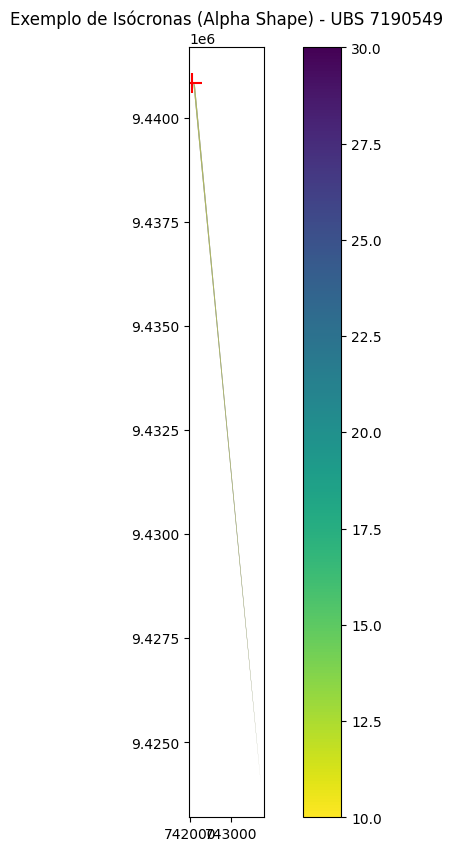

In [9]:
# Salvar em GeoPackage (Padrão moderno, melhor que Shapefile)
filename = "isocronas_ubs_teresina_alpha.gpkg"
gdf_isocronas_final.to_file(filename, driver="GPKG")
print(f"Arquivo salvo: {filename}")

# --- Visualização Rápida (Check de Qualidade) ---
# Vamos plotar as isócronas de 10, 20 e 30 min de UMA UBS aleatória
try:
    # Pega uma UBS qualquer que tenha resultados
    ubs_exemplo = gdf_isocronas_final['id_ubs'].iloc[0]
    subset = gdf_isocronas_final[gdf_isocronas_final['id_ubs'] == ubs_exemplo]

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plotar da maior para a menor para ver as camadas
    subset.sort_values('tempo_limite', ascending=False).plot(
        column='tempo_limite', 
        ax=ax, 
        alpha=0.5, 
        cmap='viridis_r', # Verde = perto, Roxo = longe
        legend=True
    )
    
    # Plotar o ponto da UBS em cima
    ubs_ponto = ubs_gdf[ubs_gdf['cnes'] == ubs_exemplo]
    ubs_ponto.plot(ax=ax, color='red', marker='+', markersize=200, label='Local UBS')
    
    plt.title(f"Exemplo de Isócronas (Alpha Shape) - UBS {ubs_exemplo}")
    plt.show()
    
except IndexError:
    print("Não há dados suficientes para plotar.")

In [9]:
tree = cKDTree(node_points)
distancias, indices = tree.query(list(zip(ubs_gdf.geometry.x, ubs_gdf.geometry.y)), k=1)

NameError: name 'node_points' is not defined

In [10]:
# Adiciona o ID do nó mais próximo no DataFrame da UBS
ubs_gdf['no_origem'] = [node_ids[i] for i in indices]

In [11]:
# --- CÉLULA 5: Função Alpha Shape ---
def calcular_isocrona(grafo, no_origem, tempo, alpha=0.00002):
    try:
        # 1. Dijkstra: Acha todos os nós a X minutos
        nos_alcancados = nx.single_source_dijkstra_path_length(
            grafo, source=no_origem, cutoff=tempo, weight='travel_time_min'
        )
        
        # 2. Recupera coordenadas (pontos)
        pontos = []
        for n in nos_alcancados:
            if n in grafo.nodes and 'x' in grafo.nodes[n]:
                pontos.append((grafo.nodes[n]['x'], grafo.nodes[n]['y']))
        
        if len(pontos) < 4: return None
        
        # 3. Desenha o Polígono
        return alphashape.alphashape(pontos, alpha)
        
    except Exception as e:
        return None

In [13]:
# --- CÉLULA 7: Exportação ---
gdf_iso = gpd.GeoDataFrame(resultados, crs="EPSG:31983")
gdf_iso.to_file("isocronas_alpha_shapes.gpkg", driver="GPKG")
print(f"Geradas {len(gdf_iso)} isócronas.")

Geradas 3 isócronas.


In [ ]:
# Função para calcular isócrona precisa
def calcular_isocrona_alpha(grafo, no_origem, tempo_minutos, alpha=0.003):
    """
    Gera um polígono de isócrona usando Alpha Shapes para respeitar a morfologia urbana.
    
    Parâmetros:
    - grafo: Grafo de ruas (NetworkX) com atributo 'travel_time' nas arestas.
    - no_origem: ID do nó da UBS no grafo.
    - tempo_minutos: Tempo máximo de viagem.
    - alpha: Parâmetro de "aperto" do polígono. 
             0 = Convex Hull (frouxo). 
             >0 = Concave Hull (apertado). 
             Para graus decimais (lat/lon), comece testando 100 ou mais.
             Para UTM (metros), use valores pequenos como 0.003.
    """
    
    tempo_segundos = tempo_minutos * 60
    
    # 1. Obter subgrapho alcançável (Service Area na Rede)
    # Isso garante que só pegamos nós que realmente dá para chegar dirigindo
    try:
        subgrafo = nx.ego_graph(grafo, no_origem, radius=tempo_segundos, distance='travel_time')
    except Exception as e:
        print(f"Erro ao calcular ego_graph: {e}")
        return None

    # 2. Extrair coordenadas dos nós alcançados
    # Assumindo que seu grafo tem atributos 'x' e 'y' (padrão OSMnx/City2Graph)
    pontos_nos = [ (data['x'], data['y']) for node, data in subgrafo.nodes(data=True) ]
    
    if len(pontos_nos) < 4: # Precisa de min pontos para formar área
        return None
        
    # 3. Gerar Alpha Shape (A mágica acontece aqui)
    # Se o alpha for None, a biblioteca tenta achar o ideal sozinha (pode demorar)
    isocrona_poly = alphashape.alphashape(pontos_nos, alpha)
    
    # Tratamento de erro se o resultado não for um Polígono válido
    if isocrona_poly.is_empty:
        return None
        
    return isocrona_poly